## **Parameters**

In [2]:
! pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.4 MB/s eta 0:00:00


In [3]:
# PyTorch for deep learning operations
import torch
import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms

# PyTorch data loading and utilities
# import torch.utils.data as data
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing

# Additional PyTorch modules and libraries
import os
import random
# import glob
import cv2  # OpenCV for image processing

# Transfer Learning model library
import timm

# Data manipulation and handling
# import numpy as np
# import json
import requests
import zipfile
# import collections

# COCO dataset tools
from pycocotools.coco import COCO

# Hugging Face Transformers library for BERT models
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertConfig, DistilBertTokenizer
import torch.nn.functional as F

# Image processing and augmentations
import albumentations as A

# Visualization and progress tracking
import tqdm
from tqdm import tqdm

# Image handling
from PIL import Image
import matplotlib.pyplot as plt

# Additional utility for iterating over combinations
import itertools
import numpy as np

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR100

# image
import skimage
from PIL import Image
import random

import torch
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import torch.optim as optim

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import urllib.request
import zipfile
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset


import torchvision
import torch
import torch.nn as nn
from tqdm import tqdm

In [4]:
class CFG:
    max_length = 128
    batch_size = 64
    num_workers = 4
    projection_dim = 256
    dropout_rate = 0.1
    context_input_dim = 3
    num_head = 4
    num_layers = 1
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    context_encoder_lr = 1e-3
    fusion_lr = 1e-3
    lr = 1e-3
    weight_decay = 1e-3
    patience = 5
    factor = 0.8
    epochs = 100
    image_size = 224
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_directory = "datasets"
    train_annotation_file = os.path.join(data_directory, "annotations", "captions_train2014.json")
    val_annotation_file = os.path.join(data_directory, "annotations", "captions_val2014.json")
    image_dir = os.path.join(data_directory, "train2014")
    image_dir_val = os.path.join(data_directory, "val2014")
    bert_name = "bert-base-uncased"
    vit_name = "vit_base_patch16_224"


## **COCO dataset**

In [ ]:
# Load Coco dataset

def download_dataset(data_dir="../datasets"):
    # Create caption and image directories
    annotations_dir = os.path.join(data_dir, "annotations")
    images_dir = os.path.join(data_dir, "train2014")

    # Download annotations (captions)
    zip_file = os.path.join(annotations_dir, "annotations.zip")
    url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
    response = requests.get(url, stream=True)
    # write chunk in zip file
    with open(zip_file, "wb") as f:
        # 8192 = 8KB chunks (block or piece of data)
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    # unzip file
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)  # Extract all contents to the specified directory
    os.remove(zip_file)

    # Download train images
    zip_file = os.path.join(images_dir, "train2014.zip")
    url = "http://images.cocodataset.org/zips/train2014.zip"
    response = requests.get(url, stream=True)
    # write chunk in zip file
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    # unzip file
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)  # Extract all contents to the specified directory
    os.remove(zip_file)

    # Download val images
    images_dir = os.path.join(data_dir, "val2014")
    zip_file = os.path.join(images_dir, "val2014.zip")
    url = "http://images.cocodataset.org/zips/val2014.zip"
    response = requests.get(url, stream=True)
    # write chunk in zip file
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    # unzip file
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)  # Extract all contents to the specified directory
    os.remove(zip_file)

! mkdir datasets
! mkdir datasets/annotations
! mkdir datasets/train2014
! mkdir datasets/val2014

download_dataset("datasets")

In [ ]:
# Build  image-caption pairs

def make_pairs(annotation_json_file, image_dir, max_captions=3):
    coco = COCO(annotation_json_file)
    image_ids = list(coco.imgs.keys())

    image_caption = []

    for image_id in image_ids:
        num_caption = 0
        # image_info: list of one dict [{}]
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_dir, image_info["file_name"])
        # annotation_ids: list of caption ids to image_id []
        annotation_ids = coco.getAnnIds(image_id)
        # annotations: list of dictionary, each dictionary for one caption [{}, {}, ..., {}]
        annotations = coco.loadAnns(annotation_ids)
        for annotation in annotations:
            if 'caption' in list(annotation.keys()) and num_caption < max_captions:
                caption = annotation['caption']
                image_caption.append((image_path, caption))
                num_caption += 1

    return image_caption


training_pairs = make_pairs(CFG.train_annotation_file, CFG.image_dir, 5) # 413.915 -> 82.783 images
#validation_pairs = make_pairs(CFG.val_annotation_file, CFG.image_dir_val, 5) # 202.520
#training_pairs += validation_pairs

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


In [ ]:
training_pairs = sorted(training_pairs, key=lambda x: x[0])

In [ ]:
coco_images, coco_captions = zip(*training_pairs)

In [ ]:
len(coco_captions)

413915

In [ ]:
coco_images[:10]

('datasets/train2014/COCO_train2014_000000000009.jpg',
 'datasets/train2014/COCO_train2014_000000000009.jpg',
 'datasets/train2014/COCO_train2014_000000000009.jpg',
 'datasets/train2014/COCO_train2014_000000000009.jpg',
 'datasets/train2014/COCO_train2014_000000000009.jpg',
 'datasets/train2014/COCO_train2014_000000000025.jpg',
 'datasets/train2014/COCO_train2014_000000000025.jpg',
 'datasets/train2014/COCO_train2014_000000000025.jpg',
 'datasets/train2014/COCO_train2014_000000000025.jpg',
 'datasets/train2014/COCO_train2014_000000000025.jpg')

In [ ]:
coco_captions[:10]

('Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.',
 'A giraffe eating food from the top of the tree.',
 'A giraffe standing up nearby a tree ',
 'A giraffe mother with its baby in the forest.',
 'Two giraffes standing in a tree filled area.',
 'A giraffe standing next to a forest filled with trees.')

In [ ]:
# Take unique images
unique_images = set()
unique_pairs = [(item[0], item[1]) for item in training_pairs if item[0] not in unique_images
                and not unique_images.add(item[0])]

coco_images, _ = zip(*unique_pairs)
len(coco_images)

82783

## **Load Models**

In [ ]:
# Load model
from text_image.addition import Model
path ="text_image/weights"
model = Model(device=CFG.device)
model.load_state_dict(torch.load(os.path.join(path, "model.pt"), map_location=CFG.device))
model.eval()

In [ ]:
# Load image features
coco_image_features = torch.load(os.path.join(path, "coco_image_embeddings.pt"), map_location=CFG.device)
coco_image_features.shape

torch.Size([82783, 256])

In [ ]:
# Load text features
coco_text_features = torch.load(os.path.join(path, "coco_caption_embeddings.pt"), map_location=CFG.device)
coco_text_features.shape

torch.Size([413915, 256])

# **Matching**

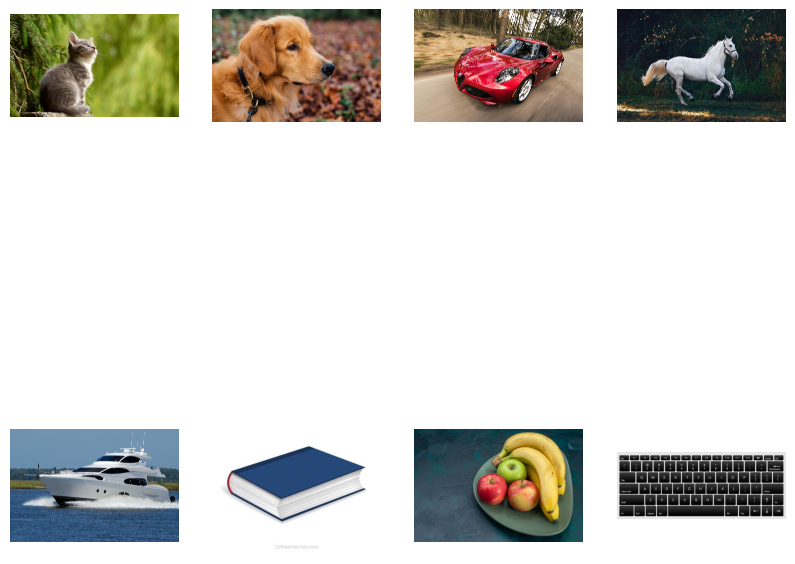

In [7]:
# Image Examples
image_paths = [
    "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg",
    "https://images.all-free-download.com/images/graphiclarge/adorable_animal_breed_canine_cute_dog_doggy_603714.jpg",
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?cs=srgb&dl=pexels-pixabay-210019.jpg&fm=jpg",
    "https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg",
    "https://images.pexels.com/photos/163236/luxury-yacht-boat-speed-water-163236.jpeg?cs=srgb&dl=pexels-pixabay-163236.jpg&fm=jpg",
    "https://i.pinimg.com/736x/81/a7/4a/81a74a1948bea28626d9aa2008191c09.jpg",
    "https://img.freepik.com/free-photo/front-view-different-fruit-composition-apples-bananas-dark-blue-desk-fruit-fresh-mellow-exotic-tropical_140725-53049.jpg",
    "https://t4.ftcdn.net/jpg/03/11/60/31/360_F_311603103_BoOOZ7Kzg9AKmAFLtjKshuGBFJWOGlHI.jpg"
]
fig, axes = plt.subplots(2, 8//2, figsize=(10, 10))

for image, ax in zip(image_paths, axes.flatten()):
      image = model.load_image(image)
      ax.imshow(image)
      ax.axis("off")
plt.show()

In [ ]:
# Encode the two first images
features = model.encode_image(image_paths[:2], outputs="average")
features.shape

torch.Size([2, 256])

In [ ]:
# Encode the two first images
features = model.encode_image(image_paths[:2], outputs="min")
features.values.shape

torch.Size([2, 256])

In [ ]:
# Encode the two first images
features = model.encode_image(image_paths[:2], outputs="max")
features.values.shape

torch.Size([2, 256])

In [ ]:
# Encode the two first images
features = model.encode_image(image_paths[:2], outputs="sequence")
features.shape

torch.Size([2, 197, 256])

In [ ]:
# Encode texts
features = model.encode_text(["a cat", "a dog"], outputs="average")
features.shape

torch.Size([2, 256])

In [ ]:
# Encode texts
features = model.encode_text(["a cat", "a dog"], outputs="min")
features.values.shape

torch.Size([2, 256])

In [ ]:
# Encode texts
features = model.encode_text(["a cat", "a dog"], outputs="sequence")
features.shape

torch.Size([2, 4, 256])

In [ ]:
# Matching between images and texts
probs, indices = model.matching(image_paths, ["Cat", "Dog", "Car", "Horse", "Boat", "Book", "Banana", "Apple", "Keyboard"], top_k=3,
               strategy="softmax")
print("Probabilities: ", probs)
print("Indices: ", indices)

Probabilities:  tensor([[0.8782, 0.0320, 0.0164],
        [0.9784, 0.0051, 0.0043],
        [0.9426, 0.0161, 0.0124],
        [0.8227, 0.1263, 0.0168],
        [0.9222, 0.0267, 0.0176],
        [0.3557, 0.1558, 0.0881],
        [0.5151, 0.4293, 0.0110],
        [0.8579, 0.1248, 0.0044]])
Indices:  tensor([[0, 2, 5],
        [1, 6, 8],
        [2, 8, 6],
        [3, 1, 8],
        [4, 2, 8],
        [5, 3, 2],
        [7, 6, 2],
        [8, 7, 6]])


In [11]:
# Image retrieval
probs, indices = model.image_retrieval("Cat", image_paths=image_paths, n=8)
print("Probalities", probs)
print("Indices", indices)

Probalities tensor([ 0.7044,  0.1159,  0.0102, -0.0106, -0.0482, -0.0529, -0.0683, -0.0862])
Indices tensor([0, 5, 6, 1, 4, 2, 3, 7])


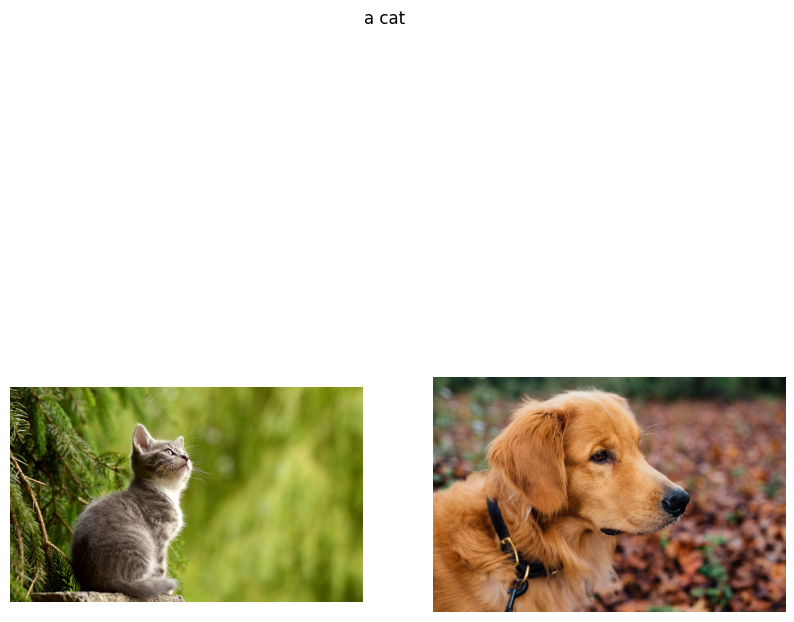

In [ ]:
# Image retrieval
probs, indices = model.image_retrieval("a cat", image_paths=image_paths, n=2, plot=True)

In [ ]:
# Image retrieval: Giving image features
model.image_retrieval("a cat", image_paths=image_paths, image_embeddings=coco_image_features[:8], n=3, plot=True)

In [10]:
# Text retrieval
texts, values = model.text_retrieval(image_paths[0], ["Cat", "Dog", "Car", "Horse", "Boat", "Book", "Banana", "Apple", "Keyboard"], n=2)
print("Text:", texts)
print("Probs:", values)

Text: ['Cat', 'Dog']
Probs: tensor([0.7044, 0.0881])


In [ ]:
# Text retrieval : Giving text features
model.text_retrieval(image_paths[0], ["Cat", "Dog", "Car", "Horse", "Boat", "Book", "Banana", "Apple", "Keyboard"],
                     text_embeddings=coco_text_features[:8], n=4)

# **Image Retrieval - MSCOCO**

In [ ]:
# Examples
queries = {
    0: "an ocean",
    1:"a cat",
    2:"a dog",
    3:"a white dog",
    4:"one dog sitting on the grass",
    5:"two dog sitting on the grass",
    6: "a family standing next to the ocean on a sandy beach with a surf board",
    7: "a group of people dancing in a party",
    8: "a train",
    9: "an apple",
    10: "a red apple",
    11: "a green apple",
    12: "the company apple",
    13: "a giraffe in the forest",
    14: "a giraffe in a house",

    15: 'a stunning golden sunset over the calm ocean waves',
    16: 'a joyful family enjoying a lovely picnic in the park',
    17: "an adorable puppy happily chasing a ball in the backyard",
    18: "an enchanting view of a historic city with charming architecture",
    19: "a vibrant hot air balloon festival filling the sky with a burst of colors",

    20: "at the beach, a group of friends is having fun, playing beach volleyball, and constructing sandcastles",
    21: "enjoying a day at the seashore, a bunch of friends engages in beach volleyball and constructs sandcastles",
    22: "on the sandy beach, friends have a great time playing beach volleyball and building sandcastles",

    23: "a cat sitting on a bookshelf next to a vase of flowers",
    24: "children playing on the beach, with the ocean waves crashing behind them",
    25: "a family having a picnic under a shady tree in the park",
    26: "a dog running outside the house, chasing after a ball",

    27: "a cozy living room",
    28: "a cozy living room with a fireplace",
    29: "a cat sleeping on the sofa",
    30: "a cozy living room with a fireplace and a cat sleeping on the sofa",

    31: "a dog in the house",
    32: "a dog out the house",
    33:"a dog next to the door",
    34: "a dog and a cat"

}

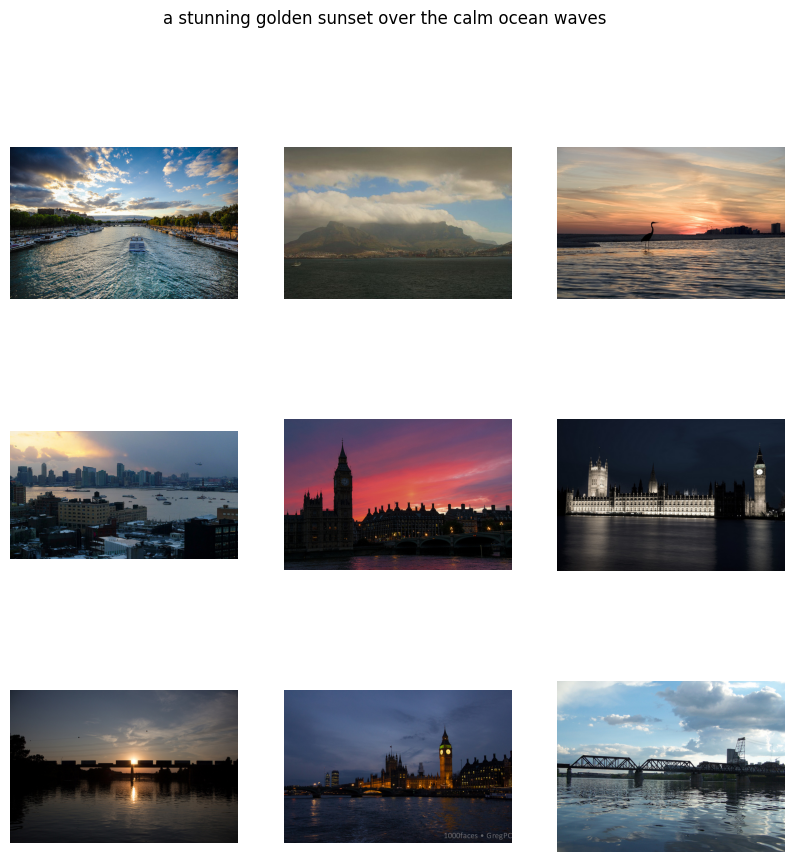

In [ ]:
probs, indices = model.image_retrieval(queries[np.random.randint(35)], image_paths=coco_images,
                                       image_embeddings=coco_image_features, n=9, plot=True)

# **Text retrieval - MSCOCO**

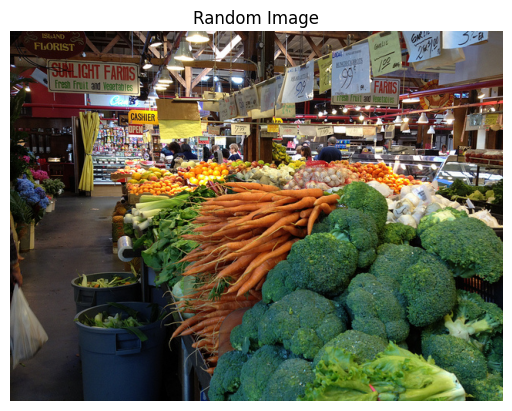

In [ ]:
# Text retrieval : Giving text features
texts, probs = model.text_retrieval(coco_images[np.random.randint(len(coco_images))], coco_captions,
                     text_embeddings=coco_text_features, n=5, plot_image=True)

In [ ]:
# Matched Texts with probalities
for text, prob in zip(texts, probs):
  print(f"{prob:.2f}: {text}")

0.80: Vast quantity of vegetables, for the taking at a market
0.80: a pile of vegetables s up for sale in a market
0.80: a table that has some vegetables on it
0.80: some black trays with many different types of vegetables
0.79: Farmers market showing aisles of fresh fruit and vegetables.


# **Zero-shot Classification**

In [ ]:
# Create a Dataset Generator

class CustomCIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Convert PIL Image to NumPy array
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        return img, label

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
class_names = testset.classes
# Apply Albumentations transform
testset = CustomCIFAR10Dataset(testset, transform=model.image_preprocessor)

# Example usage
sample_image, sample_label = testset[0]
print("Transformed Image Shape:", sample_image.shape)
print("Label:", sample_label)

Files already downloaded and verified
Transformed Image Shape: torch.Size([3, 224, 224])
Label: 3


In [ ]:
# Number of images (numpy array)
print("Shape: ", testset.dataset.data.shape)

Shape:  (10000, 32, 32, 3)


In [ ]:
# Create DataLoader for the test set
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
for images, labels in testloader:
    break

print(images.shape)

torch.Size([64, 3, 224, 224])


In [ ]:
def zero_shot_classification(model, dataloader, unique_class_names):

    accuracy = {f"top_{i+1}_accuracy": 0 for i in range(5)}
    # Encode label names
    text_features = model.encode_text(texts=unique_class_names)
    text_features = F.normalize(text_features, p=2, dim=-1)

    for id, batch in enumerate(tqdm(dataloader, desc="Testing")):
        image_tensors, labels = batch
        # Encode images
        image_features = model.encode_image(image_tensors=image_tensors)
        image_features = F.normalize(image_features, p=2, dim=-1)
        
        dot_similarity = (image_features @ text_features_n.T) * torch.exp(
            torch.tensor(2.5).to(model.device))
        text_probs = (10.0 * dot_similarity).softmax(dim=-1)
        _, top_k = text_probs.cpu().topk(5, dim=-1)
        for i in range(5):
            accuracy[f"top_{i+1}_accuracy"] += torch.sum(torch.any(top_k[:, :i+1] == labels.view(-1, 1), dim=-1)).item()

    return accuracy


In [1]:
# Addition Method
accuracy = zero_shot_classification(model, testloader, class_names)
for name, score in accuracy.items():
    print(f"{name}: {score/testset.dataset.data.shape[0]}")

top_1_accuracy: 0.7826
top_2_accuracy: 0.8869
top_3_accuracy: 0.925
top_4_accuracy: 0.9487
top_5_accuracy: 0.9648


In [ ]:
def visualization(testloader, class_names):
    all_image_features = []
    all_labels = []
    with torch.no_grad():
      for id, sample in enumerate(testloader):
          image_tensors, labels = sample

          image_features = model.encode_image(image_tensors=image_tensors)
          all_image_features.append(image_features)
          all_labels += labels
          if id == 12:
              break
    image_features = torch.cat(all_image_features, dim=0)
    text_labels = [class_names[id] for id in all_labels]


    sns.set_theme(style="darkgrid")
    # T-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(image_features.cpu().detach().numpy())

    # Visualization
    color_palette = sns.color_palette("tab10", n_colors=10)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=text_labels, palette=color_palette)
    plt.xlabel('Component 1', fontsize=20)
    plt.ylabel('Component 2', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
    plt.show()

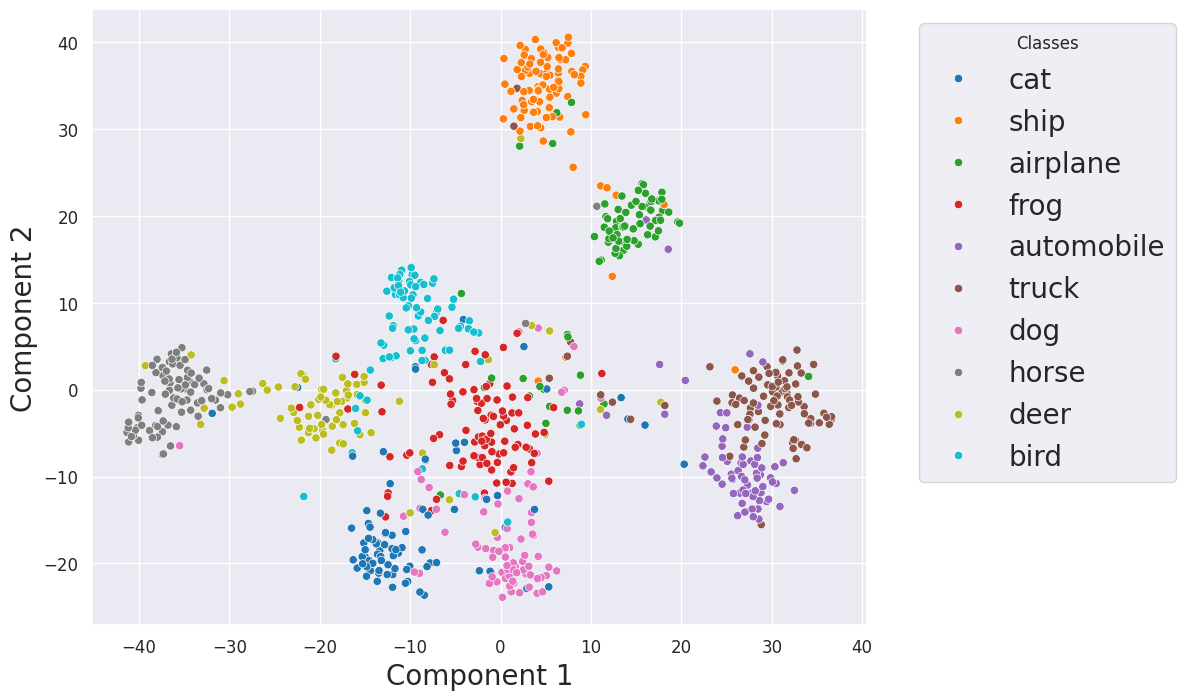

In [ ]:
visualization(testloader, class_names)

# **Linear Classifier**

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=100, hidden_dim=128, trainable=False, device='cpu', *args, **kwargs):
        super(LinearClassifier, self).__init__(*args, **kwargs)
        self.model = pretrained_model
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.trainable = trainable
        self.device = device
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fusion_encoder.projection_dim, hidden_dim),
            nn.Linear(hidden_dim, self.num_classes)
        )
        for parameter in self.model.parameters():
            parameter.requires_grad = self.trainable
        self.to(self.device)
        self.model.to(self.device)
        self.classifier.to(self.device)

    def forward(self, inputs):
        image_features = self.model.encode_image(image_tensors=inputs)
        logits = self.classifier(image_features)
        return logits

    def accuracy(self, data_loader):
        top_accuracy = {f"top_{i+1}_accuracy": 0 for i in range(5)}
        total_samples = 0
        with torch.no_grad():
            self.eval()
            for inputs, labels in tqdm(data_loader, desc='Validation'):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                total_samples += labels.size(0)
                logits = self(inputs)
                _, predicted_top_k = torch.topk(logits, 5, dim=1)
                for i in range(5):
                    top_accuracy[f"top_{i+1}_accuracy"] += torch.sum(torch.any(
                        predicted_top_k[:, :i+1] == labels.view(-1, 1), dim=-1)).item()

        for name in top_accuracy:
            top_accuracy[name] /= total_samples

        return top_accuracy

    def __call__(self, inputs):
        return self.forward(inputs)

In [ ]:
class CustomCIFAR100Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Convert PIL Image to NumPy array
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        return img, label

In [ ]:
def train_classifier(pretrained_model, device='cpu', epochs=100, trainable=False):
    # Load train dataset
    train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
    train_data = CustomCIFAR100Dataset(train_data, transform=pretrained_model.image_preprocessor)
    # Load test dataset
    test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
    test_data = CustomCIFAR100Dataset(test_data, transform=pretrained_model.image_preprocessor)
    # Create DataLoader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)
    # Create Model
    model = LinearClassifier(pretrained_model=pretrained_model, device=device, trainable=trainable)
    # Define parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        if (epoch + 1) % 10 == 0:
            # Validate the model on the test set
            top_accuracy = model.accuracy(test_loader)
            print(top_accuracy)

    # Save the fine-tuned model if needed
    torch.save(model.state_dict(), 'fine_tuned_model.pt')

In [ ]:
if __name__ == "__main__":
    train_classifier(pretrained_model=model, device=CFG.device)

Files already downloaded and verified
Files already downloaded and verified


Validation: 100%|██████████| 157/157 [01:44<00:00,  1.50it/s]


# **Fine-tuning**

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=200, hidden_dim=256, trainable=False, device='cpu', *args, **kwargs):
        super(LinearClassifier, self).__init__(*args, **kwargs)
        self.model = pretrained_model
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.trainable = trainable
        self.device = device
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fusion_encoder.projection_dim, hidden_dim),
            nn.Linear(hidden_dim, self.num_classes)
        )
        for parameter in self.model.parameters():
            parameter.requires_grad = self.trainable
        self.to(self.device)
        self.model.to(self.device)
        self.classifier.to(self.device)


    def forward(self, input):
        image_features = self.model.encode_image(image_tensors=input)
        logits = self.classifier(image_features)
        return logits

    def accuracy(self, data_loader):
        top_accuracy = {f"top_{i+1}_accuracy":0 for i in range(5)}
        total_samples = 0
        with torch.no_grad():
          model.eval()
          for input, label in tqdm(data_loader, desc='Validation'):
              input, label = input.to(self.device), label.to(self.device)
              total_samples += label.size(0)
              logits = self(input.to(self.device))
              _, predicted_topk = torch.topk(logits, 5, dim=1)
              for i in range(5):
                  top_accuracy[f"top_{i+1}_accuracy"] += torch.sum(torch.any(predicted_topk[:, :i+1] == label.view(-1, 1), dim=-1)).item()

        for name in top_accuracy:
            top_accuracy[name] /= total_samples

        return top_accuracy

    def __call__(self, input):
        return self.forward(input)

In [ ]:
def download_and_unzip_tiny_imagenet(download_dir='tiny_imagenet'):
    # Create the download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Download TinyImageNet dataset
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_file_path = os.path.join(download_dir, 'tiny_imagenet.zip')
    urllib.request.urlretrieve(url, zip_file_path)

    # Extract the downloaded zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)

    # Remove the zip file
    os.remove(zip_file_path)

    print("TinyImageNet dataset downloaded and unzipped successfully!")

# Usage
download_and_unzip_tiny_imagenet()

TinyImageNet dataset downloaded and unzipped successfully!


In [ ]:
class CustomTinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.classes = os.listdir(os.path.join(root_dir, 'train'))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        if self.train:
            self.data_dir = os.path.join(root_dir, 'train')
            self.annotations_file = os.path.join(root_dir, 'wnids.txt')
            with open(self.annotations_file, 'r') as f:
                self.classes = sorted([line.strip() for line in f.readlines()])
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
            self.image_paths = []
            for cls in self.classes:
                images_dir = os.path.join(self.data_dir, cls, 'images')
                for img_name in os.listdir(images_dir):
                    self.image_paths.append((os.path.join(images_dir, img_name), self.class_to_idx[cls]))
        else:
            self.data_dir = os.path.join(root_dir, 'val')
            self.annotations_file = os.path.join(root_dir, 'val', 'val_annotations.txt')
            self.image_paths = []
            with open(self.annotations_file, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split('\t')
                    img_name = parts[0]
                    img_cls = parts[1]
                    img_cls_idx = self.class_to_idx[img_cls]
                    img_path = os.path.join(self.data_dir, 'images', img_name)
                    self.image_paths.append((img_path, img_cls_idx))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, label

In [ ]:
def train_classifier(pretrained_model, device='cpu', epochs=100, trainable=False, root_dir="tiny_imagenet/tiny-imagenet-200"):
    # Load train dataset
    train_data = CustomTinyImageNetDataset(root_dir=root_dir, transform=pretrained_model.image_preprocessor, train=True)
    # Load test dataset
    test_data = CustomTinyImageNetDataset(root_dir=root_dir, transform=pretrained_model.image_preprocessor, train=False)
    # Create DataLoader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)
    # Create Model
    model = LinearClassifier(pretrained_model=pretrained_model, device=device, trainable=trainable)
    # Define parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        if (epoch + 1) % 10 == 0:
            # Validate the model on the test set
            top_accuracy = model.accuracy(test_loader)
            print(top_accuracy)

    # Save the fine-tuned model if needed
    torch.save(model.state_dict(), 'fine_tuned_model.pt')

In [ ]:
if __name__ == "__main__":
    # Usage
    train_classifier(pretrained_model=model, device=CFG.device, epochs=100, trainable=True)

# **Text-Image Retrieval**

In [ ]:
# Download flickr8k on : https://www.kaggle.com/datasets/adityajn105/flickr8k

In [ ]:
! mkdir flickr8K

In [ ]:
# unzip the archive.zip
! unzip archive.zip -d flickr8K

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = self.load_annotations(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_filename, caption = self.annotations.iloc[idx]
        img_path = os.path.join(self.root_dir, img_filename)

        # Load the image
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(image=img)['image']

        return img, caption

    def load_annotations(self, annotation_file):
        # Load annotations from the CSV file into a DataFrame
        df = pd.read_csv(annotation_file)

        # Optionally, you can preprocess the DataFrame if needed
        # For example, you can merge duplicate rows or perform other data cleaning

        return df

# Define the root directory where the images are stored
root_dir = 'flickr8K/Images'

# Define the path to the annotation file
annotation_file = 'flickr8K/captions.txt'


# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_dir, annotation_file, transform=model.image_preprocessor)

# Define batch size
batch_size = 32

# Create DataLoader
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def get_embeddings(model, data_loader, device="cpu"):
    image_embeddings = []
    caption_embeddings = []
    for image_tensors, captions in tqdm(data_loader, desc="Validation"):
        image_tensors = image_tensors.to(device)  # Move image tensors to device
        image_embeddings.append(model.encode_image(image_tensors=image_tensors))
        caption_embeddings.append(model.encode_text(captions))

    image_embeddings = torch.cat(image_embeddings)
    caption_embeddings = torch.cat(caption_embeddings)

    torch.save(image_embeddings, "image_embeddings.pt")
    torch.save(caption_embeddings, "caption_embeddings.pt")
    return image_embeddings, caption_embeddings

In [ ]:
# Get text and image Embeddings
image_embeddings, caption_embeddings = get_embeddings(model=model, data_loader=data_loader, device=CFG.device)

Validation: 100%|██████████| 1265/1265 [11:05<00:00,  1.90it/s]


In [ ]:
image_embeddings.size(0)

40455

In [ ]:
# Save files in drive if working for colab
! cp image_embeddings.pt caption_embeddings.pt /content/drive/MyDrive/multimodal

In [ ]:
# Image retrieval accuracy
def image_retrieval_accuracy(model, image_embeddings, text_embeddings):
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)

    dot_similarities = text_embeddings @ image_embeddings.T
    accuracy = {}
    labels = torch.arange(start=0, end=text_embeddings.size(0))
    _, top_k = dot_similarities.cpu().topk(5100, dim=-1)
    for i in tqdm(range(100, 5100, 100),  desc='Accuracy'):
        # top_1_accuracy is the best
        accuracy[f"top_{i}_accuracy"] = (torch.sum(torch.any(top_k[:, :i] == labels.view(-1, 1), dim=-1)).item() / text_embeddings.size(0))

    return accuracy

In [3]:
# Show accuracy
image_embeddings = torch.load(os.path.join(path, "image_embeddings.pt"), map_location=CFG.device)
caption_embeddings = torch.load(os.path.join(path, "caption_embeddings.pt"), map_location=CFG.device)
accuracy = image_retrieval_accuracy(model, image_embeddings, caption_embeddings)
accuracy

{'top_100_accuracy': 0.5818181818181818,
 'top_200_accuracy': 0.6545454545454545,
 'top_300_accuracy': 0.6909090909090909,
 'top_400_accuracy': 0.7090909090909091,
 'top_500_accuracy': 0.7090909090909091,
 'top_600_accuracy': 0.7090909090909091,
 'top_700_accuracy': 0.7090909090909091,
 'top_800_accuracy': 0.7272727272727273,
 'top_900_accuracy': 0.7636363636363637,
 'top_1000_accuracy': 0.7636363636363637,
 'top_1100_accuracy': 0.7636363636363637,
 'top_1200_accuracy': 0.7636363636363637,
 'top_1300_accuracy': 0.7636363636363637,
 'top_1400_accuracy': 0.7636363636363637,
 'top_1500_accuracy': 0.7636363636363637,
 'top_1600_accuracy': 0.7636363636363637,
 'top_1700_accuracy': 0.7636363636363637,
 'top_1800_accuracy': 0.7818181818181819,
 'top_1900_accuracy': 0.7818181818181819,
 'top_2000_accuracy': 0.7818181818181819,
 'top_2100_accuracy': 0.8,
 'top_2200_accuracy': 0.8181818181818182,
 'top_2300_accuracy': 0.8363636363636363,
 'top_2400_accuracy': 0.8363636363636363,
 'top_2500_accur

In [ ]:
# Text retrieval accuracy
def text_retrieval_accuracy(model, image_embeddings, text_embeddings, dataframe):
    # Each image have 5 captions
    num_groups = dataframe.shape[0] // 5
    labels = torch.tensor([[i + j for j in range(5)] for i in range(0, num_groups*5, 5)])
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarities = image_embeddings @ text_embeddings.T
    _, top_k = dot_similarities.cpu().topk(5, dim=-1)
    accuracy = {}

    for i in tqdm(range(5),  desc='Accuracy'):
        results = []
        for row_a, row_b in zip(top_k, labels):
            set_a = set(row_a.tolist())
            set_b = set(row_b.tolist())
            # If in the retrieved texts (topk) at list i+1 texts is in right captions (5)
            result = len(set_a.intersection(set_b)) >= i+1
            results.append(result)
        # top_5_accuracy is the best (all right captions are selected)
        accuracy[f"top_{i+1}_accuracy"] = sum(results)/image_embeddings.size(0)

    return accuracy

In [ ]:
# Compute accuracy
accuracy = text_retrieval_accuracy(model, image_embeddings, caption_embeddings, custom_dataset.annotations)
accuracy

{'top_1_accuracy': 0.00017303176368804846,
 'top_2_accuracy': 2.471882338400692e-05,
 'top_3_accuracy': 0.0,
 'top_4_accuracy': 0.0,
 'top_5_accuracy': 0.0}